In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools

import snap

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

%matplotlib inline

## Data import and visualization

In [2]:
# data import
features = pd.read_csv('data/test-3/hashtag_network_16.emb', sep=' ',header=None,skiprows=1)
nodes = pd.read_csv('data/test-3/hashtag_network_nodes.csv', sep='\t')

/home/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = nodes.merge(features, left_on='id', right_on=0)

In [4]:
tags = data[data['type'] == 'tag'].drop(['type',0,'id','content'], axis=1)

In [5]:
tags.head()

,id_node,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
224698,australianbrand,2.01164,-1.69315,1.118680,-0.456479,0.040308,0.455620,0.151969,0.150807,-0.106608,-0.000689,0.338441,0.354910,-0.054363,-0.007603,-0.357618,-0.257320
224699,wanderlust,1.20519,-1.59385,0.830923,-0.244574,0.094895,0.117412,0.057274,-0.328387,-0.370488,0.183637,0.111776,0.042287,0.218048,0.298029,-0.297978,-0.026623
224700,turquoise,1.21899,-1.58412,0.871651,-0.245334,0.125506,0.197366,0.144802,0.001365,-0.035500,-0.116600,0.113278,0.197730,-0.579465,0.268561,-0.481104,-0.018877
224701,colour,1.38768,-1.42495,0.890718,-0.487771,-0.153218,-0.295195,0.023640,-0.175532,0.114866,-0.137208,0.313849,-0.028850,-0.398866,0.130311,-0.070809,0.031081
224702,lifestyle,1.55899,-1.57811,0.650095,0.347932,0.215386,0.002694,-0.037393,0.035733,0.015918,-0.221791,0.270217,-0.021869,-0.120034,-0.309395,-0.067052,-0.298328


In [6]:
tags.shape

(1692, 17)

In [7]:
# visualization over 2 dimensions
pca = PCA(n_components = 2)
pca.fit(tags[range(1, 17)])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
print(pca.explained_variance_ratio_)  

[0.12981498 0.10112983]


In [9]:
X = pca.transform(tags[range(1,17)])

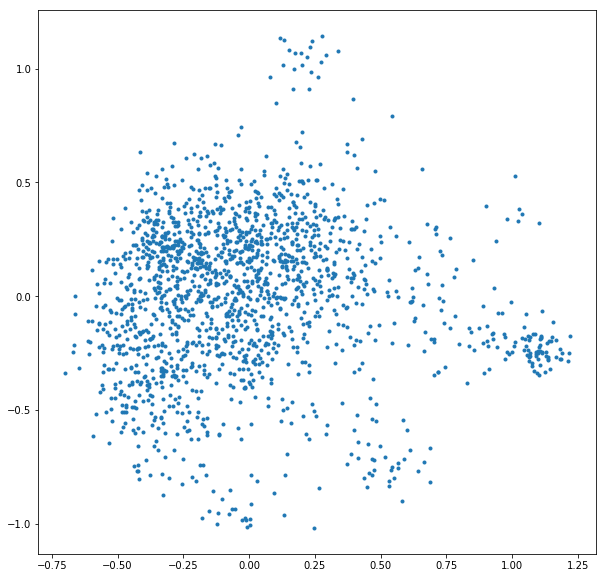

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], marker='.')

In [11]:
tags = pd.concat([tags.reset_index(), pd.DataFrame(X, columns=['pca1', 'pca2'])], axis=1)

## Test K-means

In [17]:
K = range(2, 31)

In [18]:
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=17).fit(tags[range(1, 17)])
    inertia.append(kmeans.inertia_)

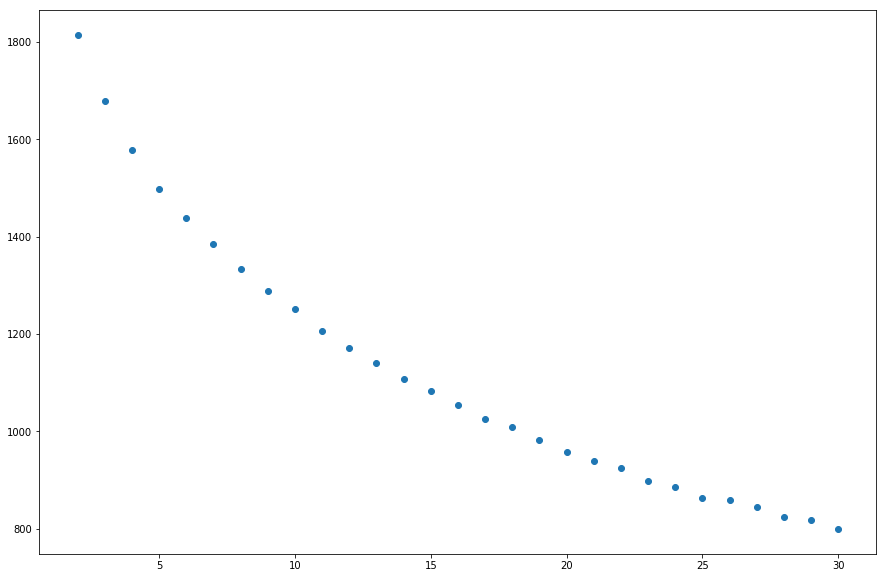

In [19]:
plt.figure(figsize=(15,10))
plt.scatter(K, inertia)

In [20]:
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=17).fit(tags[range(1, 17)])
    s = silhouette_score(X, kmeans.labels_)
    silhouette.append(s)

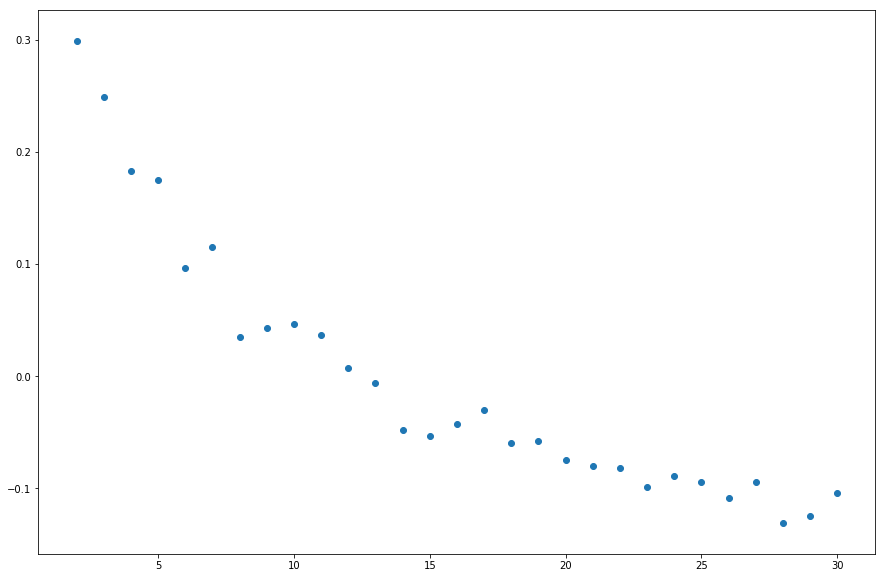

In [21]:
plt.figure(figsize=(15,10))
plt.scatter(K, silhouette)

In [22]:
test_K = 20 # given by silhouette score

In [24]:
kmeans = KMeans(n_clusters=test_K, n_init=15, max_iter=450, random_state=17).fit(tags[range(1, 17)])
cluster_labels = kmeans.labels_

In [40]:
tags['cluster_kmeans'] = cluster_labels

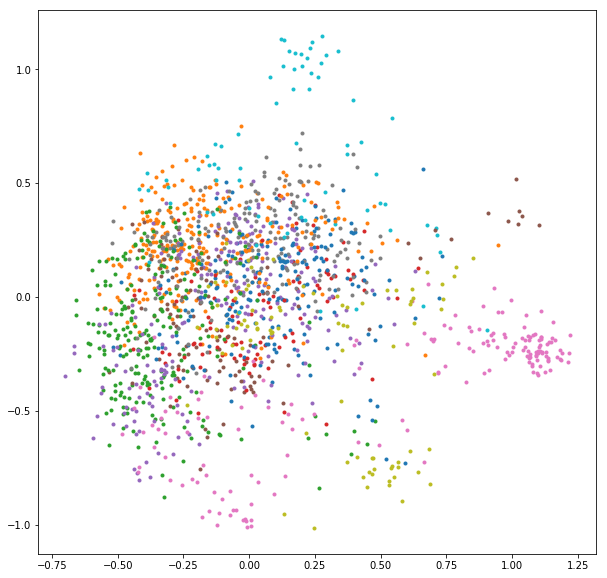

In [59]:
plt.figure(figsize=(10,10))
for i in range(test_K):
    c = tags[tags['cluster_kmeans'] == i]
    plt.scatter(c['pca1'], c['pca2'], marker='.')

In [33]:
for i in range(test_K):
    c = tags[tags['cluster'] == i]
    print c.shape[0], c['id_node'][:10].values

72 ['styleinspo' 'lifestyleblogger' 'purse' 'sunglasses' 'vintagestyle'
 'orangecounty' 'happyplace' 'palmtrees' 'livemusic' 'frenchstyle']
206 ['saturdaynight' 'weekendvibes' 'friyay' 'sunday' 'friday' 'weekend'
 'sundays' 'coffee' 'monday' 'tgif']
110 ['manhattan' 'france' 'holiday' 'seaside' 'pool' 'switzerland' 'usa'
 'mydubai' 'blueskies' 'ontheroad']
69 ['sydney' 'keychain' 'australia' 'musthave' 'bohostyle' 'streetstyle'
 'bali' 'paris' 'santorini' 'pfw']
151 ['colour' 'crystal' 'sustainable' 'texture' 'monochrome' 'chic' 'timeless'
 'white' 'interiordesign' 'india']
98 ['winetime' 'newyorkcity' 'cocktails' 'wine' 'foodporn' 'chocolate'
 'gourmet' 'winelover' 'ny' 'delicious']
109 ['interiorinspo' 'interiors' 'homedesign' 'interiorinspiration' 'decora'
 'homedecor' 'gardens' 'blueandwhite' 'gardendesign' 'tablesetting']
151 ['accessories' 'shopping' 'handbag' 'lookbook' 'bags' 'fashionweek'
 'runway' 'chanel' 'louisvuitton' 'suede']
26 ['in' 'international' 'weddingstyle' 'luxur

## Test DBSCAN

In [12]:
def getKgraph(dist_matrix, k):
    k_graph = []
    for i in range(tags.shape[0]):
        knn_dist = np.mean(sorted(distMatrix[i])[1:K+1])
        k_graph.append(knn_dist)
    return k_graph

In [13]:
distMatrix = squareform(pdist(tags[range(1,17)]))

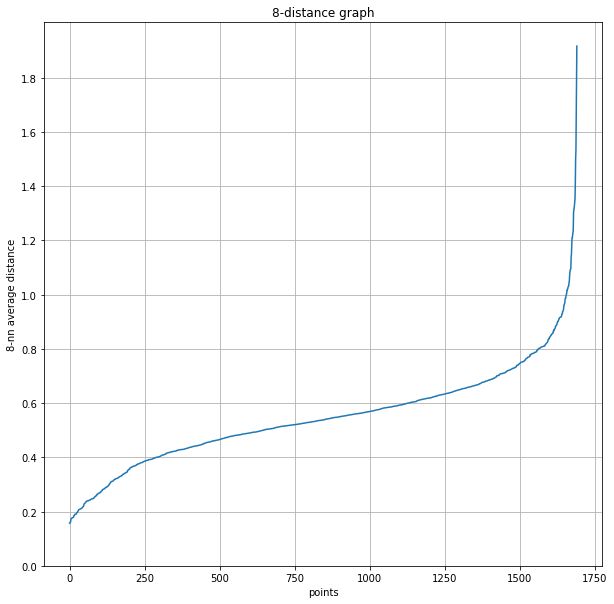

In [14]:
K = 8
k_graph = getKgraph(distMatrix, K)

plt.figure(figsize=(10,10))
plt.title('{}-distance graph'.format(K))
plt.xlabel('points')
plt.ylabel('{}-nn average distance'.format(K))

plt.plot(sorted(k_graph))
plt.yticks(np.arange(0, max(k_graph), step=0.2))
plt.grid(True)

In [15]:
epsilon = 0.5
minPts = 7
db = DBSCAN(eps = epsilon, min_samples = minPts, n_jobs = -1).fit(tags[range(1,17)])

In [16]:
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print 'Estimated number of clusters: {}'.format(n_clusters)

Estimated number of clusters: 21


In [17]:
tags['cluster_dbscan'] = labels

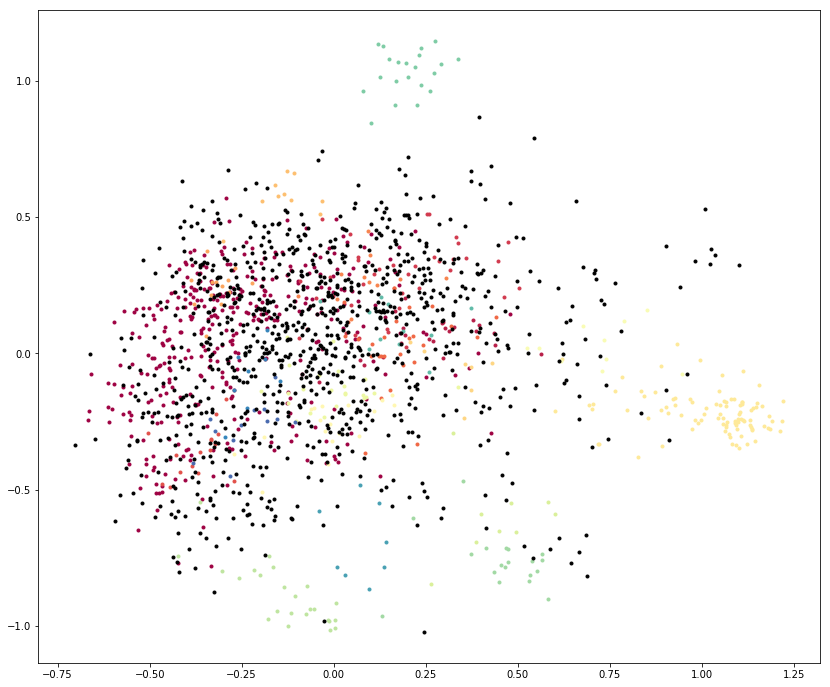

In [18]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(14,12))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    
    cluster = tags[tags['cluster_dbscan'] == k]
    plt.scatter(cluster['pca1'], cluster['pca2'], marker='.', color=col)

In [19]:
core_samples_idx = db.core_sample_indices_ 

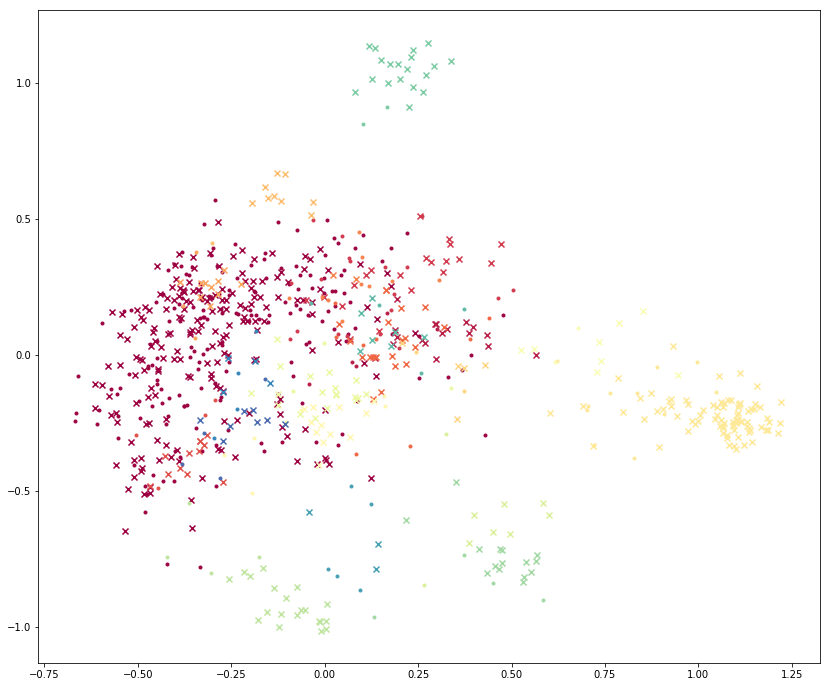

In [20]:
plt.figure(figsize=(14,12))

for k, col in zip(unique_labels, colors):
    if k != -1:
        cluster = tags[tags['cluster_dbscan'] == k]
        for index, row in cluster.iterrows():
            if index in core_samples_idx:
                mark = 'x'
            else:
                mark = '.'
                
            plt.scatter(row['pca1'], row['pca2'], marker=mark, color=col)

In [21]:
sizes = []
for c in range(n_clusters):
    cluster = tags[tags['cluster_dbscan'] == c]
    sizes.append(cluster.shape[0])

<BarContainer object of 21 artists>

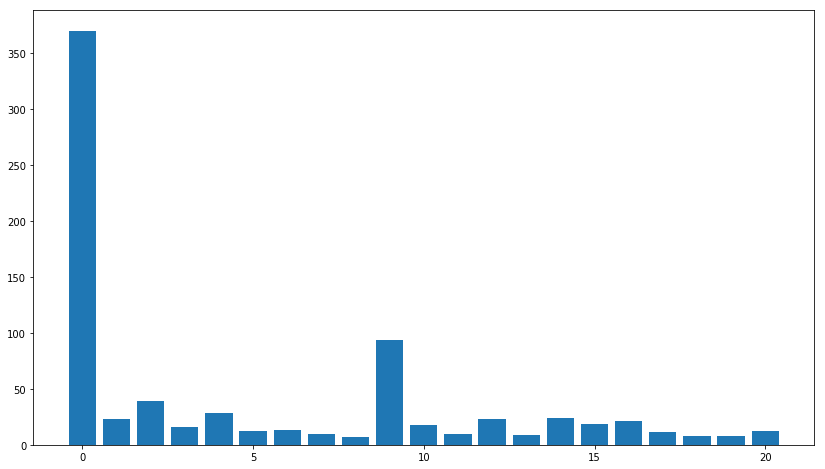

In [22]:
plt.figure(figsize=(14,8))
plt.bar(range(n_clusters), sizes)

In [24]:
for n in range(-1, n_clusters):
    c = tags[tags['cluster_dbscan'] == n]
    
    core_idx = set(c.index).intersection(set(core_samples_idx))
    n_core = len(core_idx)
    core_hashtags = c[c.index.isin(core_idx)]['id_node'].values
    
    if core_hashtags.shape[0] < 30:
        print n, c.shape[0], n_core, core_hashtags
    else:
        print n, c.shape[0], n_core, core_hashtags[:30]

-1 917 0 []
0 370 193 ['colour' 'sunday' 'friday' 'weekend' 'coffee' 'monday' 'texture' 'red'
 'moon' 'timeless' 'relax' 'flowers' 'white' 'holiday' 'easter' 'autumn'
 'relaxing' 'green' 'sunset' 'seaside' 'pool' 'flower' 'art' 'colorful'
 'artist' 'design' 'earth' 'foodporn' 'chocolate' 'gourmet']
1 23 18 ['sydney' 'keychain' 'fashiondaily' 'mochila' 'manila' 'moscow' 'seoul'
 'fashionaddict' 'streetstyleluxe' 'stylediaries' 'fashiondiaries'
 'munich' 'santamonica' 'instablogger' 'philippines' 'verao2017'
 'wayuubag' 'medellin']
2 39 20 ['necklace' 'jewellery' 'gift' 'gold' 'jewelry' 'ring' 'shop'
 'jewelrydesigner' 'dressedup' 'bridal' 'shoppingaddict' 'hollywood'
 'shoppingtime' 'beverlyhills' 'bracelet' 'jewelrydesign' 'boutiques'
 'promo' 'platinum' 'engagementring']
3 16 12 ['positano' 'amalficoast' 'ravello' 'amalfi' 'sorrento' 'costiera'
 'praiano' 'atrani' 'maiori' 'amalfitana' 'villatreville' 'casaangelina']
4 28 20 ['lifestyleblogger' 'orangecounty' 'followers' 'instacool'
 

In [26]:
with open('output/final/1_step_tags_clusters.txt', 'w') as outfile:
    outfile.write('n_cluster\tdim\thashtags\n')
    for c in range(-1, n_clusters):
        cluster = tags[tags['cluster_dbscan'] == c]
        dim = cluster.shape[0]
        if dim<100:
            outfile.write('{}\t{}\t{}\n'.format(c, dim, ','.join(list(cluster['id_node']))))
        else:
            core_idx = set(cluster.index).intersection(set(core_samples_idx))
            core_hashtags = cluster[cluster.index.isin(core_idx)]['id_node'].values
            
            outfile.write('{}\t{}\t{}\n'.format(c, dim, ','.join(list(core_hashtags[:20]))))

In [ ]:
# save also list of "noise" hashtags
#tags[tags['cluster_dbscan'] == -1]['id_node'].to_csv('output/test-3/1_step_noise_list.csv', index=None)

## Extract User Participation

In [83]:
# extract list of tags for each user
path = 'data/test-3/'

# read input network
t_net = snap.LoadEdgeListNet(path+'hashtag_network.csv', '\t')

usedtags = {}

it = t_net.BegNI()
V = t_net.GetNodes()
for i in range(V):
    nid = it.GetId()
    type = t_net.GetStrAttrDatN(nid, 'type')
    username = t_net.GetStrAttrDatN(nid, 'content')

    if type == 'user':
        tagsV = snap.TIntV()
        snap.GetNodesAtHop(t_net, nid, 2, tagsV, True)
        
        taglist = []
        for tid in tagsV:
            tagname = t_net.GetStrAttrDatN(tid, 'content')
            taglist.append(tagname)
            
        usedtags[username] = set(taglist)
    it.Next()

In [84]:
# extract list of tags for each cluster
clusterTags = {}
for c in range(-1, n_clusters):
    cluster = tags[tags['cluster_dbscan'] == c]
    clusterTags[c] = set(cluster['id_node'])

In [85]:
# compute participation of each user in each cluster (plus the "noise cluster")
tempResult = []
for u in usedtags:
    u_vector = usedtags[u]
    
    if len(u_vector)>0:
        u_result = [u]
        for c in range(-1, n_clusters):
            c_vector = clusterTags[c]
            participation = float(len(u_vector.intersection(c_vector)))/len(u_vector)
            u_result.append(participation)
    else:
        u_result = [u]+[0 for i in range(-1, n_clusters)]
    tempResult.append(tuple(u_result))

In [86]:
result_header = ['username', 'noise']+[c for c in range(n_clusters)]
participationTable = pd.DataFrame(tempResult, columns=result_header)

In [87]:
participationTable.head()

,username,noise,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
0,martaferrari9008,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,rsersale,0.423077,0.576923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,tlashab,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,charr114,0.500000,0.459459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.013514,0.0,0.013514,0.0,0.0,0.0,0.0
4,catespin,0.541667,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [88]:
for i in range(1, n_clusters):
    print participationTable[participationTable[i] != 0.0].shape[0]

290
460
305
285
215
305
63
127
375
243
62
381
107
251
92
128
125
79
99
68


In [89]:
participationTable.to_csv('output/final/1_step_user_participation.csv', index=None)

In [90]:
# compute distinct users covered effectively included in the analysis
users = []
for i in range(1, n_clusters):
    u = list(participationTable[participationTable[i] != 0.0]['username'])
    users = users + u
print len(set(users))

969


In [92]:
other_users = []
for i in ['noise', 0]:
    u = list(participationTable[participationTable[i] != 0.0]['username'])
    other_users = other_users + u
print len(set(other_users))

1262


In [94]:
len(set(other_users).intersection(set(users)))

959

In [95]:
len(set(other_users).union(set(users)))

1272

In [96]:
with open('output/final/1_step_user_groups.csv', 'w') as outfile:
    outfile.write('id_cluster\tnum_users\tlist_users\n')
    for i in range(1, n_clusters):
        group = participationTable[participationTable[i] != 0.0]
        group = group.sort_values(by=i, ascending = False)
        
        dim = group.shape[0]
        userlist = list(group.apply(lambda x: tuple((x['username'], x[i])), axis=1))
        outfile.write('{}\t{}\t{}\n'.format(i, dim, str(userlist).strip('[]')))

## Community Network Visualization

In [97]:
path = 'output/final/'

#### 1. User and clusters graph

Edges that connect users to communities

In [99]:
edgetable = []

for i in range(1, n_clusters):
    group = participationTable[participationTable[i] > 0.0]
    
    
    userlist = [tuple((i, x['username'], x[i])) for index, x in group.iterrows()]
    edgetable = edgetable + userlist

In [100]:
edges = pd.DataFrame(edgetable, columns=['source','target','weight'])
edges.to_csv(path + 'user_cluster_edges.csv', index=None)

Nodes with size proportional to #hastags in the community

In [106]:
# size of cluster is the number of hashtags
def computeSize(cluster):
    return  tags[tags['cluster_dbscan'] == cluster].shape[0]

# label for now is the set of hashtags (need to manual define a name if possible)
def computeLabel(cluster):
    return  ','.join(list(tags[tags['cluster_dbscan'] == cluster]['id_node']))

In [102]:
nodes = pd.DataFrame(columns=['id', 'type'])

In [107]:
# cluster nodes
n1 = pd.DataFrame(edges['source'].unique(), columns=['id'])
n1['type'] = 'cluster'
n1['size'] = n1['id'].apply(lambda x: computeSize(x))
n1['label'] = n1['id'].apply(lambda x: computeLabel(x))

In [108]:
# user nodes
n2 = edges[['target']]
n2['type'] = 'user'
n2.columns = ['id', 'type']
n2['size'] = 1
n2['label'] = n2.apply(lambda x: x['id'], axis=1)

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
nodes = pd.concat([n1, n2])
nodes.drop_duplicates().to_csv(path + 'user_cluster_nodes.csv', index=None)

### 2. Cluster relationships only

Edges weight is given by the number of users that two clusters have in common

In [113]:
edgetable = []

for c1, c2 in itertools.combinations(range(1, n_clusters), 2):
    list1 = set(participationTable[participationTable[c1] > 0.0]['username'])
    list2 = set(participationTable[participationTable[c2] > 0.0]['username'])

    w = len(list1.intersection(list2))
    
    
    edgetable.append(tuple((c1,c2,w)))

In [114]:
edges = pd.DataFrame(edgetable, columns=['source','target','weight'])
edges.to_csv(path + 'cluster_edges.csv', index=None)

In [116]:
n1 = pd.DataFrame(range(1,n_clusters), columns=['id'])
n1['size'] = n1['id'].apply(lambda x: computeSize(x))
n1['label'] = n1['id'].apply(lambda x: computeLabel(x))

In [117]:
n1.to_csv(path + 'cluster_nodes.csv', index=None)